In [1]:
from importlib.metadata import version

pkgs = [
    "huggingface_hub",  # to download pretrained weights
    "tokenizers",       # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

huggingface_hub version: 0.35.3
tokenizers version: 0.22.1
torch version: 2.8.0+cu126


- This notebook supports both the base model and the reasoning ("thinking") model; which model to use can be controlled via the following flag:

In [2]:
USE_REASONING_MODEL = True
# Uses the base model if USE_REASONING_MODEL = False

USE_INSTRUCT_MODEL = False
# Uses the instruct mode (without reasoning) if
# USE_REASONING_MODEL = True
# USE_INSTRUCT_MODEL = True
# This setting does have no effect if USE_REASONING_MODEL = False

&nbsp;
# 1. Architecture code

In [3]:
import torch
import torch.nn as nn


class FeedForward(nn.Module):
    def __init__(self, cfg):
        # cfg is a dictionary with keys: emb_dim, hidden_dim, dtype, for each of the fc layers we pass it through embedding and hidden dims
        # dtype is the data type for the layers, e.g. torch.float32
        # fc1 is the projection layer, fc2 is the gating layer, fc3 is the output layer that returns to the original embedding dimension
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

    def forward(self, x):
        # x is the input tensor of shape (batch_size, seq_len, emb_dim)
        # we apply the three linear layers with a SiLU activation and gating mechanism
        # return the output tensor of shape (batch_size, seq_len, emb_dim)
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = nn.functional.silu(x_fc1) * x_fc2
        return self.fc3(x)

In [4]:
class RMSNorm(nn.Module):
    # Root Mean Square Layer Normalization
    def __init__(self, emb_dim, eps=1e-6, bias=False, qwen3_compatible=True):
        # set up the parameters for the RSMNorm, including the embedding dimension, epsilon for numerical stability
        super().__init__()
        self.eps = eps
        self.qwen3_compatible = qwen3_compatible
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

    def forward(self, x):
        # this is where the normalization happens
        # x is the input tensor of shape (batch_size, seq_len, emb_dim)
        # we compute the variance across the last dimension (emb_dim) and normalize
        # we then scale and shift the normalized tensor
        # return the normalized tensor of the same shape as input
        input_dtype = x.dtype

        if self.qwen3_compatible:
            x = x.to(torch.float32)

        variance = x.pow(2).mean(dim=-1, keepdim=True)
        norm_x = x * torch.rsqrt(variance + self.eps)
        norm_x = norm_x * self.scale

        if self.shift is not None:
            norm_x = norm_x + self.shift

        return norm_x.to(input_dtype)

In [5]:
# rope is rotary positional embedding that is used in the attention mechanism to encode positional information
# we precompute the sine and cosine values for the positions and head dimensions
# then apply the rotary transformation to the input tensor
def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))

    # Generate position indices
    positions = torch.arange(context_length, dtype=dtype)

    # Compute the angles
    angles = positions.unsqueeze(1) * inv_freq.unsqueeze(0)  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin


def apply_rope(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    # Split x into first half and second half
    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half

    # Adjust sin and cos shapes
    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    # Apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    # It's ok to use lower-precision after applying cos and sin rotation
    return x_rotated.to(dtype=x.dtype)

In [6]:
# Grouped Query Attention mechanism with RoPE and optional normalization
# this attention mechanism groups keys and values to reduce computation
# it also applies rotary positional embeddings (RoPE) to the queries and keys to preserve positional information

class GroupedQueryAttention(nn.Module):
    def __init__(
        self, d_in, num_heads, num_kv_groups, head_dim=None, qk_norm=False, dtype=None
    ):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        if head_dim is None:
            assert d_in % num_heads == 0, "`d_in` must be divisible by `num_heads` if `head_dim` is not set"
            head_dim = d_in // num_heads

        self.head_dim = head_dim
        self.d_out = num_heads * head_dim

        self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

        self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

        if qk_norm:
            self.q_norm = RMSNorm(head_dim, eps=1e-6)
            self.k_norm = RMSNorm(head_dim, eps=1e-6)
        else:
            self.q_norm = self.k_norm = None

    def forward(self, x, mask, cos, sin):
        b, num_tokens, _ = x.shape

        # Apply projections
        queries = self.W_query(x)  # (b, num_tokens, num_heads * head_dim)
        keys = self.W_key(x)       # (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)   # (b, num_tokens, num_kv_groups * head_dim)

        # Reshape
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

        # Optional normalization
        if self.q_norm:
            queries = self.q_norm(queries)
        if self.k_norm:
            keys = self.k_norm(keys)

        # Apply RoPE
        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        # Expand K and V to match number of heads
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        # Attention
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores / self.head_dim**0.5, dim=-1)

        context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        return self.out_proj(context)

In [7]:
class TransformerBlock(nn.Module):
    # A single transformer block with grouped query attention and feed-forward network
    # This block applies attention and feed-forward layers with residual connections and layer normalization.
    # It is designed to process a sequence of input embeddings and produce an output sequence of the same length.

    def __init__(self, cfg):
        super().__init__()
        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            head_dim=cfg["head_dim"],
            num_kv_groups=cfg["n_kv_groups"],
            qk_norm=cfg["qk_norm"],
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.norm2 = RMSNorm(cfg["emb_dim"], eps=1e-6)

    def forward(self, x, mask, cos, sin):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x, mask, cos, sin)  # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x + shortcut  # Add the original input back

        return x

In [8]:
class Qwen3Model(nn.Module):
    # setting up the Qwen3 model architecture
    # This class defines the overall model structure, including token embeddings,
    # multiple transformer blocks, final normalization, and output projection to vocabulary.
    # It also includes mechanisms to capture embeddings for classification tasks.
    def __init__(self, cfg):
        super().__init__()

        # Main model parameters
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.trf_blocks = nn.ModuleList(  # ModuleList since Sequential can only accept one input, and we need `x, mask, cos, sin`
            [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = RMSNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

        # Reusuable utilities
        if cfg["head_dim"] is None:
            head_dim = cfg["emb_dim"] // cfg["n_heads"]
        else:
            head_dim = cfg["head_dim"]
        cos, sin = compute_rope_params(
            head_dim=head_dim,
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"]
        )
        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)
        self.cfg = cfg

        # EMBEDDING HOOK FOR CLASSIFICATION
        # These attributes allow us to capture the last hidden state (embeddings)
        # before the final output projection. This is useful for:
        # 1. Training a classifier on top of the language model
        # 2. Extracting meaningful representations of text
        # 3. Fine-tuning only the classifier while keeping the LM frozen

        self.last_hidden_state = None  # Storage for the embeddings from final_norm
        self._hook_enabled = False      # Flag to control when to capture embeddings

    # HOOK CONTROL METHODS
    def enable_embedding_hook(self):
        """
        Enable capturing of embeddings from the last hidden layer.

        When enabled, the model will store the output of final_norm
        (before the output head) in self.last_hidden_state during forward pass.

        Usage:
            model.enable_embedding_hook()
            output = model(input_ids)
            embeddings = model.get_last_hidden_state()
        """
        self._hook_enabled = True

    def disable_embedding_hook(self):
        """
        Disable embedding capture to save memory during normal text generation.

        Usage:
            model.disable_embedding_hook()
        """
        self._hook_enabled = False

    def get_last_hidden_state(self):
        """
        Retrieve the last captured hidden state (embeddings).

        Returns:
            torch.Tensor: Shape (batch_size, seq_len, emb_dim)
                         The normalized embeddings before the output projection

        Note: Returns None if hook was not enabled during forward pass

        Usage:
            embeddings = model.get_last_hidden_state()
            # For classification, typically use embeddings[:, -1, :] (last token)
            # or embeddings.mean(dim=1) (average pooling)
        """
        return self.last_hidden_state


    def forward(self, in_idx, return_embeddings=False):
        """
        Forward pass through the model.

        Args:
            in_idx: Input token indices (batch_size, seq_len)
            return_embeddings: If True, return embeddings instead of logits

        Returns:
            If return_embeddings=False: logits (batch_size, seq_len, vocab_size)
            If return_embeddings=True: embeddings (batch_size, seq_len, emb_dim)
        """
        # Forward pass
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds

        num_tokens = x.shape[1]
        mask = torch.triu(torch.ones(num_tokens, num_tokens, device=x.device, dtype=torch.bool), diagonal=1)

        for block in self.trf_blocks:
            x = block(x, mask, self.cos, self.sin)
        x = self.final_norm(x)

        # EMBEDDING CAPTURE
        # Store embeddings if hook is enabled OR if explicitly requested
        # This happens AFTER all transformer blocks and final normalization
        # but BEFORE the output projection to vocabulary
        if self._hook_enabled or return_embeddings:
            self.last_hidden_state = x

        # If embeddings are requested, return them directly (for classification)
        if return_embeddings:
            return x
        # Otherwise, return logits for language modeling

        logits = self.out_head(x.to(self.cfg["dtype"]))
        return logits

&nbsp;
# 2. Create Tokenizer   

In [9]:
# Install required packages
!pip install datasets sentencepiece

# Load TinyStories dataset
from datasets import load_dataset
print("Loading TinyStories dataset...")
ds = load_dataset("roneneldan/TinyStories")
print(f"Dataset loaded! Train split has {len(ds['train'])} stories")

# Export a subset to text file for tokenizer training
NUM_STORIES = 100000
print(f"\nExporting {NUM_STORIES:,} stories to tiny_stories.txt...")
with open("tiny_stories.txt", "w", encoding="utf-8") as f:
    for story in ds["train"]["text"][:NUM_STORIES]:
        f.write(story.strip() + "\n")
print(f"Export complete! {NUM_STORIES:,} stories exported.")

Loading TinyStories dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Dataset loaded! Train split has 2119719 stories

Exporting 100,000 stories to tiny_stories.txt...
Export complete! 100,000 stories exported.


In [10]:
# Train SentencePiece tokenizer
# choosing sentencepiece as it is a popular and efficient tokenizer library used in many NLP models including Google's T5 and ALBERT and it should be good for a qwen3 small model with the tiny stories dataset
import sentencepiece as spm

# tiny stories data set shouldn't have a huge vocabulary, so we are setting it to 8000 to limit the parameters on Qwen3 model
print("Training SentencePiece tokenizer...")
spm.SentencePieceTrainer.train(
    input="tiny_stories.txt",
    model_prefix="qwen3_tokenizer",
    vocab_size=8000,
    model_type="unigram",
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
)
print("Tokenizer training complete!")

# Create wrapper class for easy integration with model
class SimpleTokenizer:
    """Wrapper around SentencePiece for Qwen3 model compatibility"""
    def __init__(self, model_path):
        self.sp = spm.SentencePieceProcessor(model_file=model_path)
        self.vocab_size = self.sp.vocab_size()
        self.eos_token_id = self.sp.eos_id()
        self.pad_token_id = self.sp.pad_id()
        self.bos_token_id = self.sp.bos_id()
        self.unk_token_id = self.sp.unk_id()

    def encode(self, text):
        """Encode text to token IDs"""
        return self.sp.encode(text, out_type=int)

    def decode(self, ids):
        """Decode token IDs to text"""
        return self.sp.decode(ids)

# Initialize tokenizer
tokenizer = SimpleTokenizer("qwen3_tokenizer.model")
print(f"\nTokenizer initialized!")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"PAD token ID: {tokenizer.pad_token_id}")
print(f"EOS token ID: {tokenizer.eos_token_id}")

# Test the tokenizer
test_text = "Once upon a time"
test_ids = tokenizer.encode(test_text)
print(f"\nTest encoding:")
print(f"Text: '{test_text}'")
print(f"Token IDs: {test_ids}")
print(f"Decoded: '{tokenizer.decode(test_ids)}'")

Training SentencePiece tokenizer...
Tokenizer training complete!

Tokenizer initialized!
Vocab size: 8000
PAD token ID: 0
EOS token ID: 3

Test encoding:
Text: 'Once upon a time'
Token IDs: [53, 58, 9, 38]
Decoded: 'Once upon a time'


&nbsp;
# 3. Initialize model

In [11]:
# set to the Small model, we are also leaving in the original code from the reference config for the 0.6B model
# for backup purposes, all others in the template were removed.
CHOOSE_MODEL = "Small"

if CHOOSE_MODEL == "0.6B":
    # Original reference config (kept as backup)
    QWEN3_CONFIG = {
        "vocab_size": 151_936,
        "context_length": 40_960,
        "emb_dim": 1024,
        "n_heads": 16,
        "n_layers": 28,
        "hidden_dim": 3072,
        "head_dim": 128,
        "qk_norm": True,
        "n_kv_groups": 8,
        "rope_base": 1_000_000.0,
        "dtype": torch.bfloat16,
    }

elif CHOOSE_MODEL == "Small":
    # Small model targeting ~180-200M parameters
    # IMPORTANT: vocab_size must match tokenizer.vocab_size from Section 2
    QWEN3_CONFIG = {
        "vocab_size": tokenizer.vocab_size,  # Updated from tokenizer
        "context_length": 1024,              # Context window for training
        "emb_dim": 896,                      # Embedding dimension = n_heads * head_dim
        "n_heads": 14,                       # Number of attention heads
        "n_layers": 16,                      # Number of transformer layers (more layers = better reasoning)
        "hidden_dim": 3584,                  # FFN hidden dim (4x emb_dim)
        "head_dim": 64,                      # Size of each attention head
        "qk_norm": True,                     # Normalize queries and keys in GQA
        "n_kv_groups": 7,                    # Key-Value groups (n_heads/2)
        "rope_base": 10_000.0,               # RoPE theta base
        "dtype": torch.bfloat16,             # Lower precision for memory efficiency
    }

else:
    raise ValueError(f"{CHOOSE_MODEL} is not supported.")

print(f"Config for {CHOOSE_MODEL} model:")
print(f"  Vocab size: {QWEN3_CONFIG['vocab_size']:,}")
print(f"  Embedding dim: {QWEN3_CONFIG['emb_dim']}")
print(f"  Layers: {QWEN3_CONFIG['n_layers']}")
print(f"  Heads: {QWEN3_CONFIG['n_heads']}")
print(f"  Context length: {QWEN3_CONFIG['context_length']}")

Config for Small model:
  Vocab size: 8,000
  Embedding dim: 896
  Layers: 16
  Heads: 14
  Context length: 1024


In [12]:
torch.manual_seed(528)
model = Qwen3Model(QWEN3_CONFIG)

In [13]:
model

Qwen3Model(
  (tok_emb): Embedding(8000, 896)
  (trf_blocks): ModuleList(
    (0-15): 16 x TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_features=896, out_features=896, bias=False)
        (W_key): Linear(in_features=896, out_features=448, bias=False)
        (W_value): Linear(in_features=896, out_features=448, bias=False)
        (out_proj): Linear(in_features=896, out_features=896, bias=False)
        (q_norm): RMSNorm()
        (k_norm): RMSNorm()
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=896, out_features=3584, bias=False)
        (fc2): Linear(in_features=896, out_features=3584, bias=False)
        (fc3): Linear(in_features=3584, out_features=896, bias=False)
      )
      (norm1): RMSNorm()
      (norm2): RMSNorm()
    )
  )
  (final_norm): RMSNorm()
  (out_head): Linear(in_features=896, out_features=8000, bias=False)
)

- A quick check that the forward pass works before continuing:

In [14]:
model(torch.tensor([1, 2, 3]).unsqueeze(0))

tensor([[[-0.1543,  0.4160, -1.0781,  ..., -0.9492,  0.8242,  0.4531],
         [ 0.5742,  1.5938, -0.9336,  ..., -0.1768, -0.3965,  0.3457],
         [-0.1001,  1.7109, -0.8242,  ..., -0.5391, -0.6562, -0.5820]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Account for weight tying
total_params_normalized = total_params - model.tok_emb.weight.numel()
print(f"\nTotal number of unique parameters: {total_params_normalized:,}")

#model has approximately the 200M parameter target, slightly over, but performance still runs in about 30 minutes per epoch on 1 A100 40GB GPU

Total number of parameters: 207,043,456

Total number of unique parameters: 199,875,456


In [16]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 1.54 GB
bfloat16: 0.77 GB


In [17]:
# set device to GPU if available, without this the CPU is way too slow...
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device);

&nbsp;
# 4. Train Model on TinyStories

In [18]:
# Prepare training data with 60/20/20 train/val/test split
from sklearn.model_selection import train_test_split

print("Preparing training data with 60/20/20 split...")
all_stories = ds["train"]["text"][:100000]

# First split: 60% train, 40% which will become 20% val + 20% test
train_stories, temp_stories = train_test_split(
    all_stories,
    test_size=0.4,  # 40% for val+test
    random_state=528
)

# Second split: split the 40% into 20% val and 20% test
val_stories, test_stories = train_test_split(
    temp_stories,
    test_size=0.5,  # 50% of 40% = 20% of total
    random_state=528
)

print(f"Train stories: {len(train_stories):,} (60%)")      # 60,000
print(f"Validation stories: {len(val_stories):,} (20%)")   # 20,000
print(f"Test stories: {len(test_stories):,} (20%)")        # 20,000
print(f"Total: {len(train_stories) + len(val_stories) + len(test_stories):,}")

Preparing training data with 60/20/20 split...
Train stories: 60,000 (60%)
Validation stories: 20,000 (20%)
Test stories: 20,000 (20%)
Total: 100,000


In [19]:
# Create PyTorch datasets
import torch
from torch.utils.data import Dataset, DataLoader

class TinyStoriesDataset(Dataset):
    def __init__(self, stories, tokenizer, max_length=256):
        self.stories = stories
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.stories)

    def __getitem__(self, idx):
        story = self.stories[idx]
        # Tokenize
        tokens = self.tokenizer.encode(story)

        # Truncate or pad to max_length
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        else:
            # Pad with pad_token_id
            tokens = tokens + [self.tokenizer.pad_token_id] * (self.max_length - len(tokens))

        # Convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)

        # For language modeling, input is tokens[:-1], target is tokens[1:]
        return tokens[:-1], tokens[1:]

# Create datasets and set to a consistent max_length to allow the nn to run.
# when the story has too many tokens, it will be truncated, when too few, it will be padded.

train_dataset = TinyStoriesDataset(train_stories, tokenizer, max_length=256)
val_dataset = TinyStoriesDataset(val_stories, tokenizer, max_length=256)
test_dataset = TinyStoriesDataset(test_stories, tokenizer, max_length=256)

print(f"Train dataset: {len(train_dataset)} examples")
print(f"Val dataset: {len(val_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")

Train dataset: 60000 examples
Val dataset: 20000 examples
Test dataset: 20000 examples


In [20]:
# Create dataloaders
BATCH_SIZE = 16  # Adjust based on GPU memory

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Batches per epoch: 3750
Validation batches: 1250
Test batches: 1250


In [21]:
# Training setup with early stopping for computational efficiency, also allows us to crank up the epochs for a little more powerful model, but stop before overfitting
import torch.nn.functional as F
from torch.optim import AdamW

# Hyperparameters
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10  # will stop early if needed
EVAL_INTERVAL = 500  # Validate every 500 steps
PATIENCE = 5  # Stop if no improvement for 5 validation checks

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)

# Loss function (CrossEntropyLoss for language modeling)
def calculate_loss(logits, targets):
    # Reshape for cross entropy: (batch * seq_len, vocab_size) and (batch * seq_len)
    logits_flat = logits.view(-1, logits.size(-1))
    targets_flat = targets.view(-1)
    return F.cross_entropy(logits_flat, targets_flat, ignore_index=tokenizer.pad_token_id)

# Validation function
def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            loss = calculate_loss(logits, targets)
            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    model.train()
    return avg_loss

# Early stopping tracker
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"    EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=PATIENCE)

print("Training setup complete!")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Max epochs: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Eval interval: {EVAL_INTERVAL} steps")
print(f"Early stopping patience: {PATIENCE} checks")

Training setup complete!
Learning rate: 0.0003
Max epochs: 10
Batch size: 16
Eval interval: 500 steps
Early stopping patience: 5 checks


In [22]:
# Main training loop with early stopping
model.train()
global_step = 0
train_losses = []
val_losses = []
best_model_state = None
best_val_loss = float('inf')

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"{'='*60}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    epoch_loss = 0
    num_batches = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move to device
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        logits = model(inputs)
        loss = calculate_loss(logits, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track loss
        train_losses.append(loss.item())
        epoch_loss += loss.item()
        num_batches += 1
        global_step += 1

        # Print progress every 100 steps
        if (batch_idx + 1) % 100 == 0:
            avg_loss = epoch_loss / num_batches
            print(f"  Step {global_step:5d} | Batch {batch_idx + 1:4d}/{len(train_loader)} | Train Loss: {avg_loss:.4f}")

        # Validation every EVAL_INTERVAL steps
        if global_step % EVAL_INTERVAL == 0:
            val_loss = validate(model, val_loader, device)
            val_losses.append((global_step, val_loss))
            print(f"  → Validation at step {global_step}: Val Loss = {val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                print(f"    ✓ New best model! (Val Loss: {val_loss:.4f})")

            # Check early stopping
            early_stopping(val_loss)
            if early_stopping.should_stop:
                print(f"\n  Early stopping triggered at step {global_step}")
                print(f"  Best validation loss: {best_val_loss:.4f}")
                break

    # Break outer loop if early stopping triggered
    if early_stopping.should_stop:
        break

    # End of epoch validation
    epoch_avg_loss = epoch_loss / num_batches
    val_loss = validate(model, val_loader, device)
    val_losses.append((global_step, val_loss))

    print(f"\n  Epoch {epoch + 1} Complete:")
    print(f"    Average Train Loss: {epoch_avg_loss:.4f}")
    print(f"    Validation Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        print(f"    ✓ New best model! (Val Loss: {val_loss:.4f})")

    # Check early stopping at end of epoch
    early_stopping(val_loss)
    if early_stopping.should_stop:
        print(f"\n  Early stopping triggered after epoch {epoch + 1}")
        print(f"  Best validation loss: {best_val_loss:.4f}")
        break

    print()  # Blank line between epochs for readability

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✓ Loaded best model with validation loss: {best_val_loss:.4f}")

print("\nTraining complete!")

Starting training...

Epoch 1/10
  Step   100 | Batch  100/3750 | Train Loss: 4.4289
  Step   200 | Batch  200/3750 | Train Loss: 3.9934
  Step   300 | Batch  300/3750 | Train Loss: 3.7431
  Step   400 | Batch  400/3750 | Train Loss: 3.5593
  Step   500 | Batch  500/3750 | Train Loss: 3.4269
  → Validation at step 500: Val Loss = 2.8405
    ✓ New best model! (Val Loss: 2.8405)
  Step   600 | Batch  600/3750 | Train Loss: 3.3197
  Step   700 | Batch  700/3750 | Train Loss: 3.2280
  Step   800 | Batch  800/3750 | Train Loss: 3.1509
  Step   900 | Batch  900/3750 | Train Loss: 3.0861
  Step  1000 | Batch 1000/3750 | Train Loss: 3.0279
  → Validation at step 1000: Val Loss = 2.4770
    ✓ New best model! (Val Loss: 2.4770)
  Step  1100 | Batch 1100/3750 | Train Loss: 2.9742
  Step  1200 | Batch 1200/3750 | Train Loss: 2.9276
  Step  1300 | Batch 1300/3750 | Train Loss: 2.8838
  Step  1400 | Batch 1400/3750 | Train Loss: 2.8451
  Step  1500 | Batch 1500/3750 | Train Loss: 2.8098
  → Validati

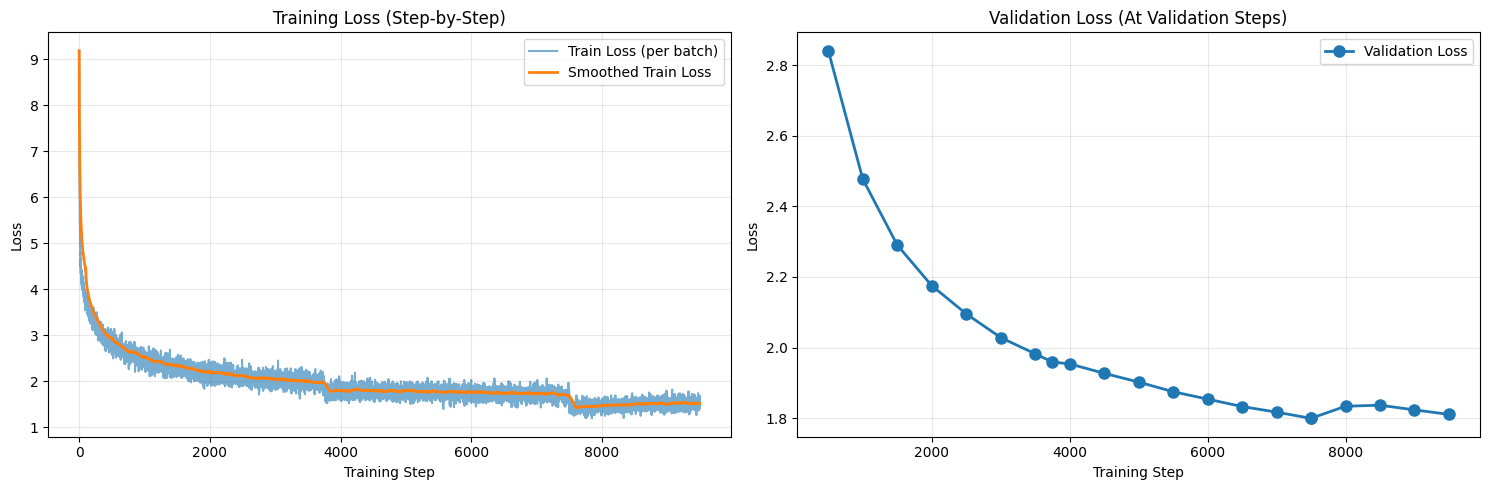


Validation checkpoints:
  Step   500: Val Loss = 2.8405
  Step  1000: Val Loss = 2.4770
  Step  1500: Val Loss = 2.2903
  Step  2000: Val Loss = 2.1754
  Step  2500: Val Loss = 2.0956
  Step  3000: Val Loss = 2.0285
  Step  3500: Val Loss = 1.9825
  Step  3750: Val Loss = 1.9593
  Step  4000: Val Loss = 1.9539
  Step  4500: Val Loss = 1.9273
  Step  5000: Val Loss = 1.9025
  Step  5500: Val Loss = 1.8752
  Step  6000: Val Loss = 1.8542
  Step  6500: Val Loss = 1.8332
  Step  7000: Val Loss = 1.8174
  Step  7500: Val Loss = 1.7998
  Step  7500: Val Loss = 1.7998
  Step  8000: Val Loss = 1.8342
  Step  8500: Val Loss = 1.8370
  Step  9000: Val Loss = 1.8238
  Step  9500: Val Loss = 1.8110


In [23]:
# Plot training progress
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training loss over steps
ax1.plot(train_losses, alpha=0.6, label='Train Loss (per batch)')
# Add smoothed line
window = 100
if len(train_losses) > window:
    smoothed = [sum(train_losses[max(0, i-window):i+1]) / min(i+1, window)
                for i in range(len(train_losses))]
    ax1.plot(smoothed, linewidth=2, label='Smoothed Train Loss')
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss (Step-by-Step)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Validation loss over time
val_steps = [step for step, _ in val_losses]
val_loss_values = [loss for _, loss in val_losses]
ax2.plot(val_steps, val_loss_values, 'o-', linewidth=2, markersize=8, label='Validation Loss')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss (At Validation Steps)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nValidation checkpoints:")
for step, loss in val_losses:
    print(f"  Step {step:5d}: Val Loss = {loss:.4f}")

&nbsp;
# 5. Save Trained Model

In [24]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': QWEN3_CONFIG,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss,
    'tokenizer_path': 'qwen3_tokenizer.model'
}, 'qwen3_small_trained.pth')

print("✓ Model saved to 'qwen3_small_trained.pth'")
print(f"  Best validation loss: {best_val_loss:.4f}")
print(f"  Total training steps: {global_step}")
print(f"  Config: {QWEN3_CONFIG['n_layers']} layers, {QWEN3_CONFIG['emb_dim']} emb_dim")

✓ Model saved to 'qwen3_small_trained.pth'
  Best validation loss: 1.7998
  Total training steps: 9500
  Config: 16 layers, 896 emb_dim


In [34]:
# evaluate on test set
test_loss = validate(model, test_loader, device)
print(f"\nTest Loss on Hold Out Stories: {test_loss:.4f}")


Test Loss on Hold Out Stories: 1.8069


&nbsp;
# 6. Test Text Generation

In [26]:
# Text generation function with temperature sampling, we will set the device to CPU as a fallback here in case anything happens, but we later set it back to the gpu if available when the function is called

def generate_text(model, tokenizer, prompt, max_tokens=30, temperature=1.0, device='cpu'):
    """Generate text from the trained model"""
    model.eval()

    # Encode prompt
    token_ids = tokenizer.encode(prompt)
    token_ids = torch.tensor(token_ids, device=device).unsqueeze(0)

    generated_tokens = []

    with torch.no_grad():
        for _ in range(max_tokens):
            # Get logits
            logits = model(token_ids)[:, -1, :]  # Last token logits

            # Apply temperature
            logits = logits / temperature

            # Sample from distribution
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Check for EOS
            if next_token.item() == tokenizer.eos_token_id:
                break

            generated_tokens.append(next_token.item())
            token_ids = torch.cat([token_ids, next_token], dim=1)

    # Decode
    full_text = tokenizer.decode(tokenizer.encode(prompt) + generated_tokens)
    return full_text

print("Text generation function ready!")

Text generation function ready!


In [27]:
# Test generation with different temperatures and prompts
# testing with the classic "Once upon a time", a couple from media, and a random prompt to see how the model performs
test_prompts = ["Once upon a time", "In a galaxy far far away", "On Thursday the princess ate a cookie", "Who lives in a pineapple under the sea?"]
temperatures = [0.2, 0.5, 0.8, 1.0]

for prompt in test_prompts:
    print(f"📝 Testing prompt: '{prompt}'")
    print("-" * 80)

    for temp in temperatures:
        print(f"\nTemperature {temp}:")
        generated = generate_text(model, tokenizer, prompt, max_tokens=30, temperature=temp, device=device)
        print(f"  {generated}")

    print("\n" + "="*80 + "\n")

📝 Testing prompt: 'Once upon a time'
--------------------------------------------------------------------------------

Temperature 0.2:
  Once upon a time, there was a little girl named Lily. She loved to play outside and explore the world around her. One day, she found a big rock that

Temperature 0.5:
  Once upon a time, there was a little girl named Lily. She loved to play outside and explore the world around her. One day, she saw a big tree in

Temperature 0.8:
  Once upon a time, there was a little girl named Lily. She loved to play with her dolls and teddy bears. One day, her mommy gave her a present.

Temperature 1.0:
  Once upon a time there was a little girl called Tara. She was only three years old and very sad. Every day, Tara's dad put her makeup in his


📝 Testing prompt: 'In a galaxy far far away'
--------------------------------------------------------------------------------

Temperature 0.2:
  In a galaxy far far away, there was a little girl named Lucy. She was very e

&nbsp;
# 7. Sentiment Classifier Training

In [28]:
# Load emotions dataset
import pandas as pd

# Load classification data from GitHub
emotions_df = pd.read_csv('https://raw.githubusercontent.com/tskunz/GenAI_Midterm_Qwen3_Small/refs/heads/main/emotions_classified.csv')

print(f"Emotions dataset loaded: {len(emotions_df)} examples")
print(f"\nColumns: {list(emotions_df.columns)}")
print(f"\nEmotion distribution:")
print(emotions_df['emotion'].value_counts())
print(f"\nSentiment distribution:")
print(emotions_df['sentiment'].value_counts())

# Show sample
print(f"\nSample rows:")
print(emotions_df.head())

Emotions dataset loaded: 16000 examples

Columns: ['text', 'emotion', 'line_number', 'sentiment']

Emotion distribution:
emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

Sentiment distribution:
sentiment
negative    8762
positive    7238
Name: count, dtype: int64

Sample rows:
                                                text  emotion  line_number  \
0                            i didnt feel humiliated  sadness            1   
1  i can go from feeling so hopeless to so damned...  sadness            2   
2   im grabbing a minute to post i feel greedy wrong    anger            3   
3  i am ever feeling nostalgic about the fireplac...     love            4   
4                               i am feeling grouchy    anger            5   

  sentiment  
0  negative  
1  negative  
2  negative  
3  positive  
4  negative  


In [29]:
# Prepare sentiment classification data
from sklearn.preprocessing import LabelEncoder

NUM_CLASSIFICATION_SAMPLES = min(5000, len(emotions_df))  # Use up to 5000

# Sample the data
emotions_sample = emotions_df.sample(n=NUM_CLASSIFICATION_SAMPLES, random_state=528)

# Encode sentiment labels (positive/negative -> 0/1)
label_encoder = LabelEncoder()
emotions_sample['sentiment_encoded'] = label_encoder.fit_transform(emotions_sample['sentiment'])

print(f"Using {NUM_CLASSIFICATION_SAMPLES} samples for classification")
print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Split into train/test (80/20)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    emotions_sample,
    test_size=0.2,
    random_state=528,
    stratify=emotions_sample['sentiment_encoded']
)

print(f"\nClassification split:")
print(f"  Train: {len(train_df)} examples")
print(f"  Test: {len(test_df)} examples")

Using 5000 samples for classification
Label mapping: {'negative': np.int64(0), 'positive': np.int64(1)}

Classification split:
  Train: 4000 examples
  Test: 1000 examples


In [30]:
# Extract embeddings from trained language model
def extract_embeddings(texts, model, tokenizer, device, max_length=128):
    """Extract embeddings from the last hidden layer using the embedding hook"""
    model.eval()
    embeddings = []

    with torch.no_grad():
        for text in texts:
            # Tokenize
            tokens = tokenizer.encode(text)
            if len(tokens) > max_length:
                tokens = tokens[:max_length]

            # Pad if needed
            if len(tokens) < max_length:
                tokens = tokens + [tokenizer.pad_token_id] * (max_length - len(tokens))

            # Convert to tensor
            input_ids = torch.tensor([tokens], device=device)

            # Get embeddings using return_embeddings parameter
            hidden_states = model(input_ids, return_embeddings=True)

            # Use mean pooling over sequence dimension (ignoring padding)
            # Shape: (1, seq_len, emb_dim) -> (emb_dim,)
            mask = (input_ids != tokenizer.pad_token_id).float().unsqueeze(-1)
            masked_hidden = hidden_states * mask
            summed = masked_hidden.sum(dim=1)
            counts = mask.sum(dim=1)
            embedding = (summed / counts).squeeze(0)  # (emb_dim,)

            embeddings.append(embedding.cpu())

    return torch.stack(embeddings)

# Extract embeddings for train and test
print("Extracting embeddings from trained model...")
print("  This may take a few minutes...")

train_embeddings = extract_embeddings(train_df['text'].tolist(), model, tokenizer, device)
test_embeddings = extract_embeddings(test_df['text'].tolist(), model, tokenizer, device)

print(f"✓ Train embeddings shape: {train_embeddings.shape}")
print(f"✓ Test embeddings shape: {test_embeddings.shape}")

Extracting embeddings from trained model...
  This may take a few minutes...
✓ Train embeddings shape: torch.Size([4000, 896])
✓ Test embeddings shape: torch.Size([1000, 896])


In [31]:
# Define sentiment classifier (simple feedforward on top of frozen embeddings)
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes=2):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, embeddings):
        return self.classifier(embeddings)

# Initialize classifier
classifier = SentimentClassifier(embedding_dim=QWEN3_CONFIG['emb_dim'], num_classes=2).to(device)

print(f"Sentiment classifier initialized")
print(f"  Input dim: {QWEN3_CONFIG['emb_dim']}")
print(f"  Output classes: 2 (positive/negative)")
print(f"  Total classifier parameters: {sum(p.numel() for p in classifier.parameters()):,}")

Sentiment classifier initialized
  Input dim: 896
  Output classes: 2 (positive/negative)
  Total classifier parameters: 262,786


In [32]:
# Train sentiment classifier
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Prepare data
train_labels = torch.tensor(train_df['sentiment_encoded'].values, dtype=torch.long).to(device)
test_labels = torch.tensor(test_df['sentiment_encoded'].values, dtype=torch.long).to(device)
train_embeddings = train_embeddings.to(device)
test_embeddings = test_embeddings.to(device)

# Training loop for classifier
NUM_CLASSIFIER_EPOCHS = 20
BATCH_SIZE_CLASSIFIER = 64

print("Training sentiment classifier...")
print(f"  Epochs: {NUM_CLASSIFIER_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE_CLASSIFIER}")

classifier.train()
for epoch in range(NUM_CLASSIFIER_EPOCHS):
    epoch_loss = 0
    num_batches = 0

    # Mini-batch training
    for i in range(0, len(train_embeddings), BATCH_SIZE_CLASSIFIER):
        batch_embeddings = train_embeddings[i:i+BATCH_SIZE_CLASSIFIER]
        batch_labels = train_labels[i:i+BATCH_SIZE_CLASSIFIER]

        # Forward pass
        outputs = classifier(batch_embeddings)
        loss = criterion(outputs, batch_labels)

        # Backward pass
        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Print progress
    avg_loss = epoch_loss / num_batches
    if (epoch + 1) % 5 == 0:
        print(f"  Epoch {epoch+1}/{NUM_CLASSIFIER_EPOCHS} | Loss: {avg_loss:.4f}")

print("\n✓ Classifier training complete!")

Training sentiment classifier...
  Epochs: 20
  Batch size: 64
  Epoch 5/20 | Loss: 0.5383
  Epoch 10/20 | Loss: 0.4779
  Epoch 15/20 | Loss: 0.4328
  Epoch 20/20 | Loss: 0.4284

✓ Classifier training complete!


SENTIMENT CLASSIFIER EVALUATION

1. Accuracy: 0.7310 (73.10%)
   ✓ Requirement met: Accuracy > 50%

2. Classification Report (Precision, Recall, F1):
              precision    recall  f1-score   support

    negative       0.70      0.88      0.78       551
    positive       0.79      0.55      0.65       449

    accuracy                           0.73      1000
   macro avg       0.75      0.71      0.71      1000
weighted avg       0.74      0.73      0.72      1000

3. Confusion Matrix:
   True Negatives:   486 | False Positives:   65
   False Negatives:  204 | True Positives:   245


<Figure size 800x600 with 0 Axes>

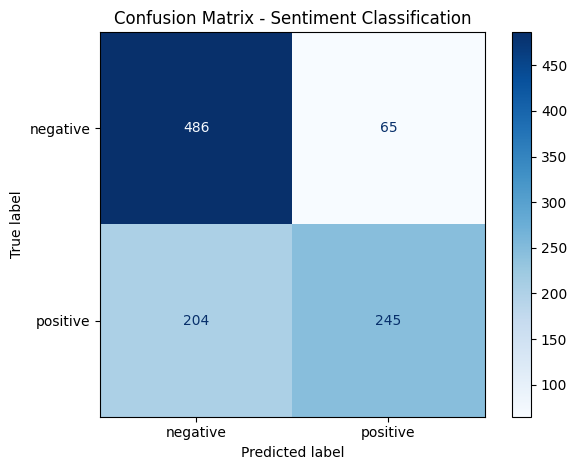

In [33]:
# Evaluate classifier (Assignment Requirements v.1, v.2, v.3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

classifier.eval()
with torch.no_grad():
    test_outputs = classifier(test_embeddings)
    test_predictions = torch.argmax(test_outputs, dim=1).cpu().numpy()

test_labels_np = test_labels.cpu().numpy()

# 1. Accuracy (must be > 50%)
accuracy = accuracy_score(test_labels_np, test_predictions)

# 2. Classification Report (includes precision, recall, f1)
print("="*60)
print("SENTIMENT CLASSIFIER EVALUATION")
print("="*60)
print(f"\n1. Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
if accuracy > 0.5:
    print("   ✓ Requirement met: Accuracy > 50%")
else:
    print("   ✗ Warning: Accuracy below 50%")

print(f"\n2. Classification Report (Precision, Recall, F1):")
print(classification_report(test_labels_np, test_predictions, target_names=label_encoder.classes_))

# 3. Confusion Matrix
cm = confusion_matrix(test_labels_np, test_predictions)
print(f"3. Confusion Matrix:")
print(f"   True Negatives:  {cm[0,0]:4d} | False Positives: {cm[0,1]:4d}")
print(f"   False Negatives: {cm[1,0]:4d} | True Positives:  {cm[1,1]:4d}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Sentiment Classification")
plt.tight_layout()
plt.show()

print("\n" + "="*60)